In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import warnings
import sklearn
import time

In [2]:
train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")
# test.head()

In [3]:
(train.apply(lambda col: col.nunique()))
# train.dtypes

id                      15289
clonesize                   6
honeybee                    7
bumbles                    11
andrena                    16
osmia                      14
MaxOfUpperTRange            6
MinOfUpperTRange            5
AverageOfUpperTRange        5
MaxOfLowerTRange            6
MinOfLowerTRange            7
AverageOfLowerTRange        5
RainingDays                 6
AverageRainingDays          8
fruitset                 1526
fruitmass                1515
seeds                    2066
yield                     776
dtype: int64

In [4]:
train.drop('id',axis=1, inplace=True)
# test.set_index('id',inplace=True)
X = train.drop('yield',axis=1)
y = train['yield']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 33, test_size = 0.2)

Building a preliminary model with defaults:
- We are using early stopping rounds instead of cross validation.

In [6]:
xgb_1 = xgb.XGBRegressor(objective = 'reg:squarederror',
                         seed = 33,
                         early_stopping_rounds = 10,
                         eval_metric ='mae')
xgb_fit1 = xgb_1.fit(X_train, y_train,
                     verbose = True,
                     eval_set = [(X_test, y_test)])
# xgb_fit1.evals_result()

[0]	validation_0-mae:821.93021
[1]	validation_0-mae:648.71718
[2]	validation_0-mae:535.66345
[3]	validation_0-mae:464.42439
[4]	validation_0-mae:421.43717
[5]	validation_0-mae:394.42320
[6]	validation_0-mae:379.08007
[7]	validation_0-mae:369.50589
[8]	validation_0-mae:363.90014
[9]	validation_0-mae:359.77723
[10]	validation_0-mae:358.26455
[11]	validation_0-mae:357.28844
[12]	validation_0-mae:356.58875
[13]	validation_0-mae:356.19304
[14]	validation_0-mae:356.52318
[15]	validation_0-mae:356.43103
[16]	validation_0-mae:356.98846
[17]	validation_0-mae:356.96237
[18]	validation_0-mae:356.87040
[19]	validation_0-mae:357.83877
[20]	validation_0-mae:358.13598
[21]	validation_0-mae:358.08230
[22]	validation_0-mae:358.04790


Now we do Grid Search and Cross Validation

In [7]:
%%time

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.2, 0.1, 0.01, 0.05],
    'gamma': [0, 0.1, 0.25, 1],
    'reg_lambda': [0, 1, 2, 5, 10]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror',
                                seed=33,
                                subsample=0.8,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='mae',
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 1}
CPU times: user 5.64 s, sys: 888 ms, total: 6.52 s
Wall time: 3min 37s


In [8]:
best_params = optimal_params.best_params_
xgb_2 = xgb.XGBRegressor(objective='reg:squarederror',
                         seed=33,
                         early_stopping_rounds = 10,
                         eval_metric ='mae',
                         **best_params)
xgb_fit2 = xgb_2.fit(X_train, y_train,
                     verbose = True,
                     eval_set = [(X_test, y_test)])

[0]	validation_0-mae:998.73584
[1]	validation_0-mae:919.76105
[2]	validation_0-mae:850.27318
[3]	validation_0-mae:788.93328
[4]	validation_0-mae:734.49146
[5]	validation_0-mae:686.68451
[6]	validation_0-mae:644.57986
[7]	validation_0-mae:606.94257
[8]	validation_0-mae:573.50041
[9]	validation_0-mae:544.96163
[10]	validation_0-mae:519.84811
[11]	validation_0-mae:497.60863
[12]	validation_0-mae:478.64232
[13]	validation_0-mae:462.17976
[14]	validation_0-mae:447.36182
[15]	validation_0-mae:435.11241
[16]	validation_0-mae:424.26235
[17]	validation_0-mae:415.31653
[18]	validation_0-mae:407.27371
[19]	validation_0-mae:400.16598
[20]	validation_0-mae:394.26379
[21]	validation_0-mae:388.76370
[22]	validation_0-mae:384.56894
[23]	validation_0-mae:380.55910
[24]	validation_0-mae:377.18620
[25]	validation_0-mae:374.10039
[26]	validation_0-mae:371.37671
[27]	validation_0-mae:369.31190
[28]	validation_0-mae:367.24905
[29]	validation_0-mae:365.41826
[30]	validation_0-mae:364.17330
[31]	validation_0-

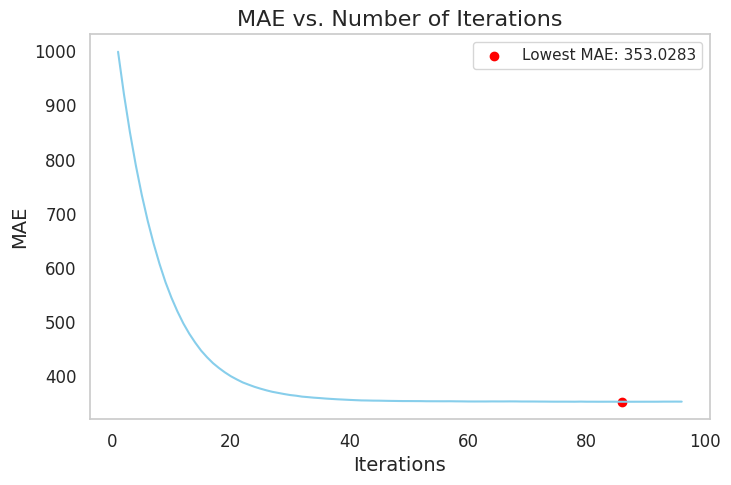

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

evals_result = xgb_fit2.evals_result()

# Extract the MAEs and number of iterations
maes = evals_result['validation_0']['mae']
iterations = range(1, len(maes) + 1)

# Find the index and value of the lowest MAE
min_mae_index = maes.index(min(maes))
min_mae_value = min(maes)

# Create the Seaborn plot with custom colors
plt.figure(figsize=(8, 5))
sns.lineplot(x=iterations, y=maes, color='skyblue')
plt.scatter(min_mae_index + 1, min_mae_value, color='red', label=f'Lowest MAE: {min_mae_value:.4f}')  # Annotate lowest MAE point
plt.title('MAE vs. Number of Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)
plt.legend()

In [31]:
y_pred = xgb_fit2.predict(X_test)
print("Best MAE:", xgb_fit2.best_score)
grid_search_results = pd.DataFrame(optimal_params.cv_results_)

Best MAE: 353.0282694964412


In [10]:
grid_search_results[grid_search_results['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
26,2.290819,0.192383,0.091710,0.034880,0,0.1,4,1,"{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",-363.180646,-361.581495,-357.605167,-360.789103,2.344128,1
106,1.620344,0.084173,0.084906,0.016658,0.1,0.1,4,1,"{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept...",-363.180646,-361.581495,-357.605167,-360.789103,2.344128,1
186,2.186097,0.202972,0.133900,0.006813,0.25,0.1,4,1,"{'gamma': 0.25, 'learning_rate': 0.1, 'max_dep...",-363.180646,-361.581495,-357.605167,-360.789103,2.344128,1
266,1.662316,0.207008,0.057581,0.022575,1,0.1,4,1,"{'gamma': 1, 'learning_rate': 0.1, 'max_depth'...",-363.180646,-361.581495,-357.605167,-360.789103,2.344128,1


In [11]:
# xgb_pred = xgb_fit1.predict(X_test)
# mean_absolute_error(y_test, xgb_pred)

In [33]:
from sklearn import metrics
metrics_df = pd.DataFrame({
    "MAE": [metrics.mean_absolute_error(y_test, y_pred)],
    "MSE": [metrics.mean_squared_error(y_test, y_pred)],
    "RMSE": [np.sqrt(metrics.mean_squared_error(y_test, y_pred))],
    "MAPE": [metrics.mean_absolute_percentage_error(y_test, y_pred)],
    "R2 Score": [metrics.r2_score(y_test, y_pred)],
})
metrics_df

,MAE,MSE,RMSE,MAPE,R2 Score
0,353.028272,324612.663623,569.747895,0.063738,0.818811
